### 아이디어
- 추세가 일정할때 주기 t가 일정하다
- 왜냐면 통계. 그리고 중앙회귀는 모든 금융상품에 일어나는 일이여서
- 추세의 변환을 감정지수로 추론한다.(보안한다)


## I. 패키지 밎 자료 불러오기

In [1]:
!pip install pymysql
!pip install sqlalchemy

     |████████████████████████████████| 43 kB 1.2 MB/s 


In [2]:
import warnings
warnings.filterwarnings('ignore')
import time
import datetime
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import operator

import base64
from io import BytesIO

from datetime import datetime, timedelta

### 1) 나중에 데이터베이스 커리해서 가져오기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls -l '/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_market/Ethereum.csv'

-rw------- 1 root root 30724 Nov 16 07:33 '/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_market/Ethereum.csv'


In [6]:
ETH = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_market/Ethereum.csv')

In [7]:
ETH

,Date,Price,Open,High,Low,Vol.,Change %
0,"Nov 12, 2021","4,667.31","4,720.50","4,807.16","4,511.96",634.59K,-1.13%
1,"Nov 11, 2021","4,720.87","4,633.98","4,778.17","4,578.66",418.61K,1.87%
2,"Nov 10, 2021","4,634.03","4,731.83","4,864.06","4,498.78",761.90K,-2.07%
3,"Nov 09, 2021","4,731.83","4,808.34","4,836.69","4,715.43",437.41K,-1.59%
4,"Nov 08, 2021","4,808.38","4,612.05","4,822.97","4,612.05",673.21K,4.26%
...,...,...,...,...,...,...,...
403,"Oct 05, 2020",353.28,352.69,354.86,348.76,4.96M,0.16%
404,"Oct 04, 2020",352.73,345.60,353.97,344.03,4.77M,2.06%
405,"Oct 03, 2020",345.60,345.78,351.04,343.74,4.48M,-0.02%
406,"Oct 02, 2020",345.68,353.06,353.61,335.91,7.27M,-2.09%


### 2) 변수 정의 밎 전처리

In [9]:
n = [7,14,30,60,90,180]
crypto = [ETH]
crypto_name = ['ETH']
bounds = [30,60,180,360,720]

In [10]:
B = []
for j,k in zip(crypto,crypto_name) :
  for i in range(len(j)):
    x = j['Price'][i]
    date_time_obj = datetime.strptime(j['Date'][i], '%b %d, %Y')
    a = date_time_obj.strftime("%Y-%m-%d")
    b = j['Vol.'][i]
    Y = [a,b,x]
    B.append(Y)
  globals()[k] = pd.DataFrame(B)
  globals()[k].columns = ['date','volume','price']
  # globals()[k] = globals()[k].set_index('date')
  print('완료')

완료


In [11]:
DF_price = ETH

In [12]:
for i in range(len(DF_price['price'])):
  DF_price['price'][i] = DF_price['price'][i].replace(',','')
for i in range(len(DF_price['volume'])):
  DF_price['volume'][i] = DF_price['volume'][i].replace('K','')  

In [13]:
DF_price

,date,volume,price
0,2021-11-12,634.59,4667.31
1,2021-11-11,418.61,4720.87
2,2021-11-10,761.90,4634.03
3,2021-11-09,437.41,4731.83
4,2021-11-08,673.21,4808.38
...,...,...,...
403,2020-10-05,4.96M,353.28
404,2020-10-04,4.77M,352.73
405,2020-10-03,4.48M,345.60
406,2020-10-02,7.27M,345.68


In [15]:
for i in range(len(DF_price['price'])):
  DF_price['price'][i] = pd.to_numeric(DF_price['price'][i], downcast = 'float')
  # DF_price['volume'][i] = pd.to_numeric(DF_price['volume'][i], downcast = 'float')

In [16]:
DF_price

,date,volume,price
0,2021-11-12,634.59,4667.31
1,2021-11-11,418.61,4720.87
2,2021-11-10,761.9,4634.03
3,2021-11-09,437.41,4731.83
4,2021-11-08,673.21,4808.38
...,...,...,...
403,2020-10-05,4.96M,353.28
404,2020-10-04,4.77M,352.73
405,2020-10-03,4.48M,345.6
406,2020-10-02,7.27M,345.68


In [17]:
DF = DF_price

## II. 이동평균선 작업

In [18]:
  for i in n:
    DF_price['MA{0};'.format(i)]= DF_price['price'].rolling(window=i).mean().shift(-(i-1))
    print('완료', 'MA{0};'.format(i))

완료 MA7;
완료 MA14;
완료 MA30;
완료 MA60;
완료 MA90;
완료 MA180;


In [19]:
DF = DF_price

## III.표준편차,Z밸류 작업

In [20]:
for i in n :
  DF_price['MA{0};SD;'.format(i)]=DF_price['price'].rolling(window=i).std().shift(-(i-1))
for i in n :
  DF_price['MA{0};z_value;'.format(i)] = (DF_price['price']-DF_price['MA{0};'.format(i)])/(DF_price['MA{0};SD;'.format(i)])

In [21]:
DF = DF_price

In [22]:
DF_price

,date,volume,price,MA7;,MA14;,MA30;,MA60;,MA90;,MA180;,MA7;SD;,MA14;SD;,MA30;SD;,MA60;SD;,MA90;SD;,MA180;SD;,MA7;z_value;,MA14;z_value;,MA30;z_value;,MA60;z_value;,MA90;z_value;,MA180;z_value;
0,2021-11-12,634.59,4667.31,4670.262835,4558.519985,4272.686320,3779.848991,3647.202995,3028.283887,94.442554,161.149943,324.648259,580.700768,533.592298,777.669147,-0.0312653,0.675086,1.21554,1.52826,1.91177,2.10761
1,2021-11-11,418.61,4720.87,4642.789969,4540.404994,4237.351986,3756.802490,3631.618327,3022.255054,119.966609,162.230677,337.642968,572.261122,523.857605,769.050385,0.650849,1.1124,1.43204,1.68466,2.07929,2.20872
2,2021-11-10,761.9,4634.03,4616.252790,4509.264265,4196.319645,3734.925989,3616.080103,3016.259387,120.361169,166.706343,351.374920,559.733764,511.786726,759.885969,0.147697,0.748415,1.24571,1.60631,1.98901,2.12896
3,2021-11-09,437.41,4731.83,4611.707101,4458.399990,4160.020654,3712.147660,3598.408773,3013.155776,120.178619,224.372253,360.721790,550.253231,503.635977,754.362352,0.999537,1.21864,1.58518,1.85311,2.25048,2.27831
4,2021-11-08,673.21,4808.38,4590.882812,4415.377110,4116.127319,3686.738326,3580.984660,3007.532387,107.896622,225.652731,368.769264,537.419283,490.949748,745.195998,2.01579,1.74163,1.8772,2.08709,2.50004,2.41661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,2020-10-05,4.96M,353.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404,2020-10-04,4.77M,352.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405,2020-10-03,4.48M,345.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
406,2020-10-02,7.27M,345.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## IV. EDA z_value

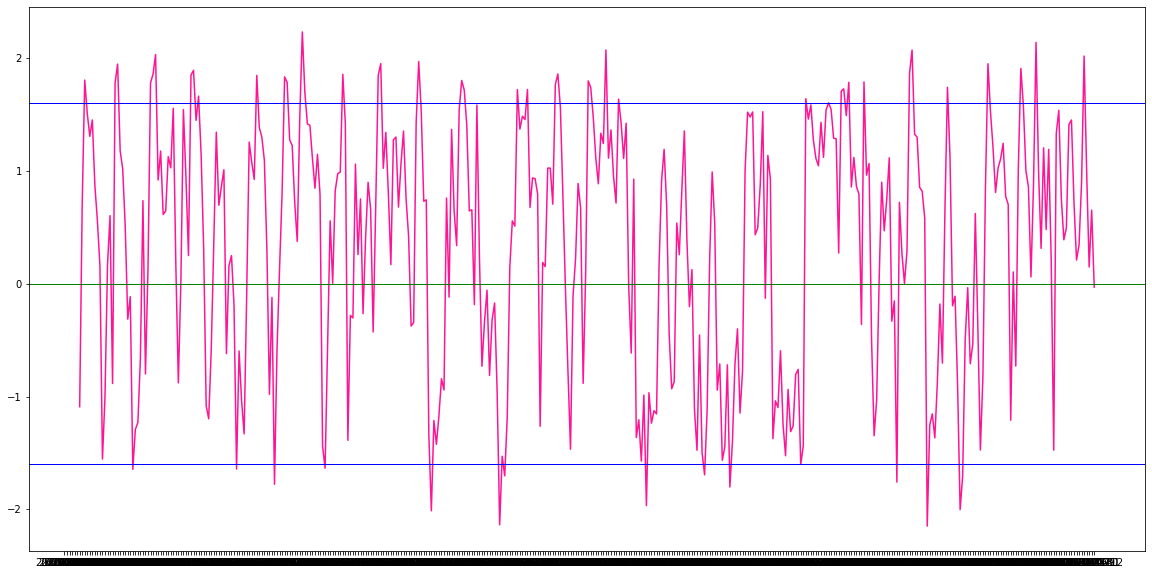

In [23]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA7;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)
plt.axhline(y=1.6, color='b', linewidth=1)
plt.axhline(y=-1.6, color='b', linewidth=1)

plt.show()


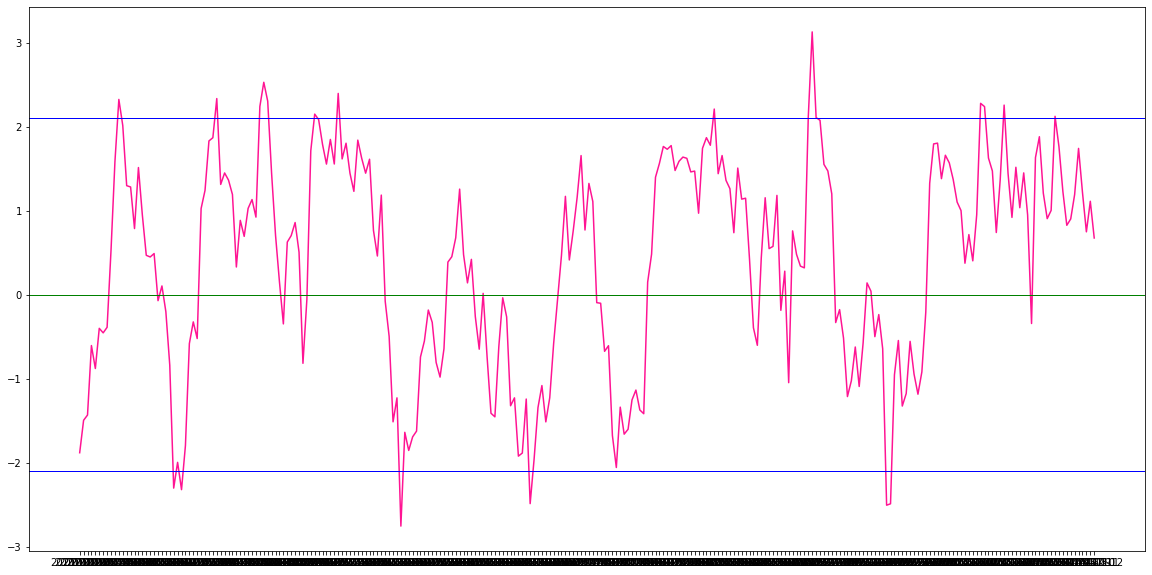

In [27]:
x_values = DF_price['date'][:260]	
# y_values = DF_price['s']
z_values = DF_price['MA14;z_value;'][:260]

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)
plt.axhline(y=2.1, color='b', linewidth=1)
plt.axhline(y=-2.1, color='b', linewidth=1)

plt.savefig('Ehtereum_MA14_Z_value.png')

plt.show()



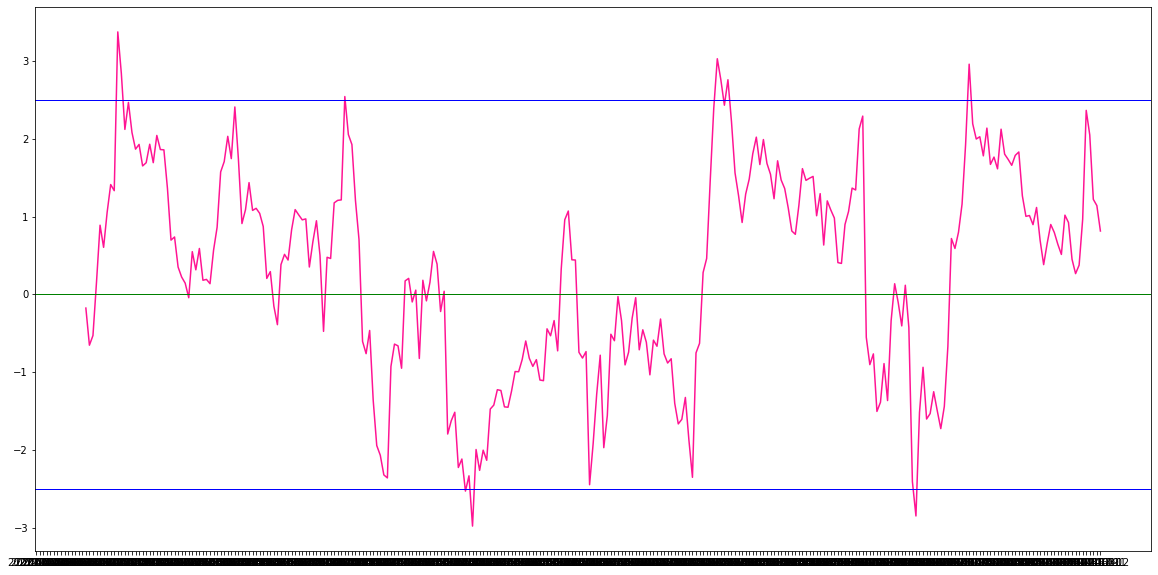

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA30;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')
plt.axhline(y=2.5, color='b', linewidth=1)
plt.axhline(y=-2.5, color='b', linewidth=1)

plt.axhline(y=0, color='g', linewidth=1)

plt.show()


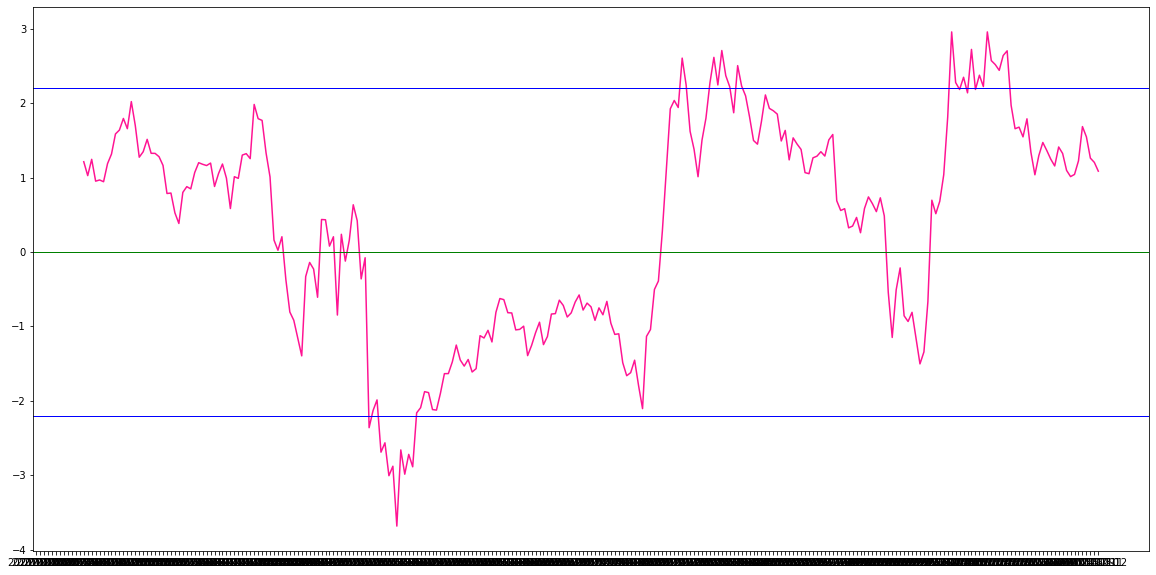

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA60;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)
plt.axhline(y=2.2, color='b', linewidth=1)
plt.axhline(y=-2.2, color='b', linewidth=1)

plt.show()

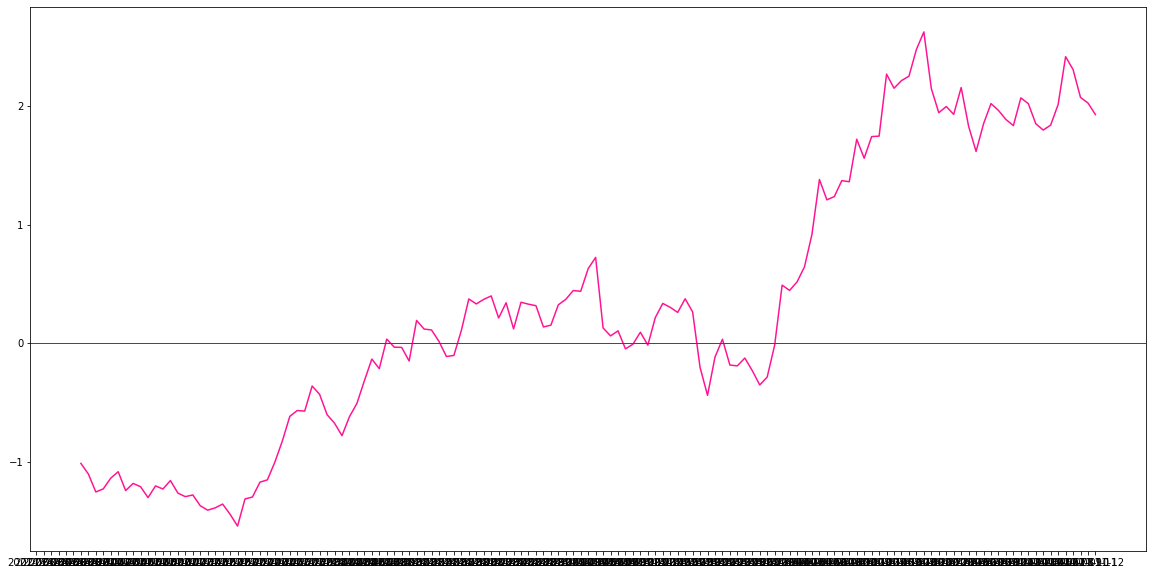

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA180;z_value;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

## V. z_value 평균이동선 작업밎 EDA

In [ ]:
  for i in n:
    DF_price['MA{0};z_value;MA{0};'.format(i)]= DF_price['MA{0};z_value;'.format(i)].rolling(window=i).mean().shift(-(i-1))
    print('완료', 'MA{0};''MA{0};z_value;MA{0};'.format(i))

완료 MA7;MA7;z_value;MA7;
완료 MA14;MA14;z_value;MA14;
완료 MA30;MA30;z_value;MA30;
완료 MA60;MA60;z_value;MA60;
완료 MA180;MA180;z_value;MA180;


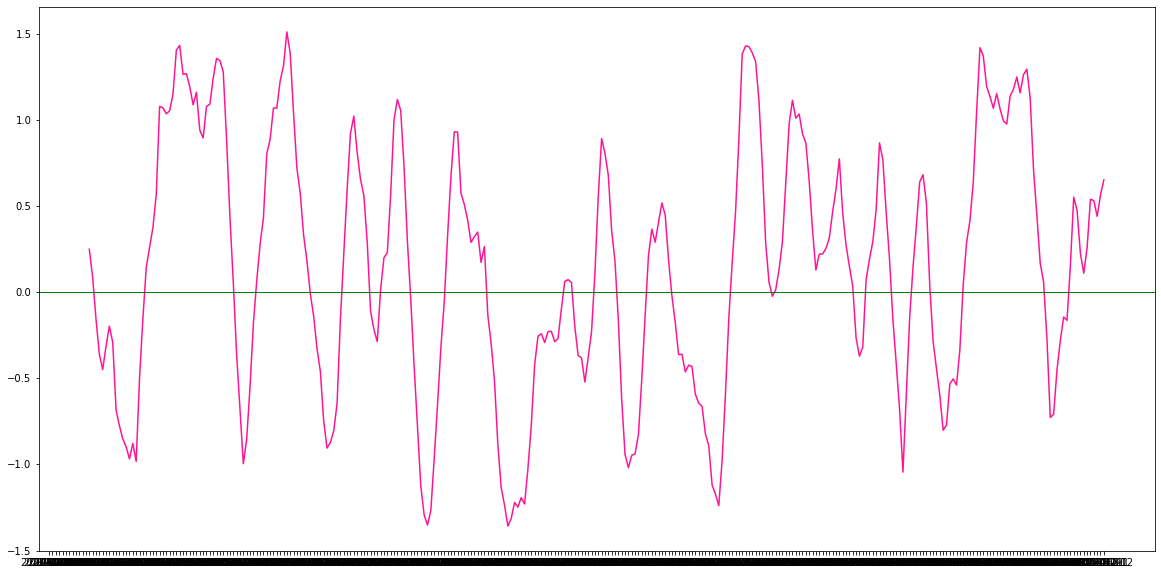

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA7;z_value;MA7;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()


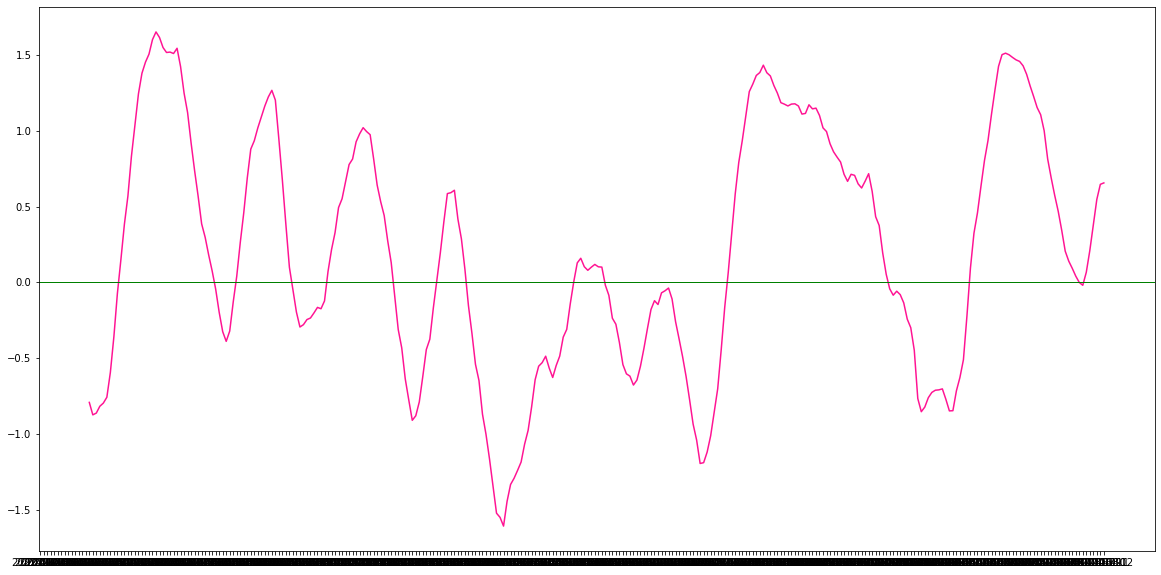

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA14;z_value;MA14;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

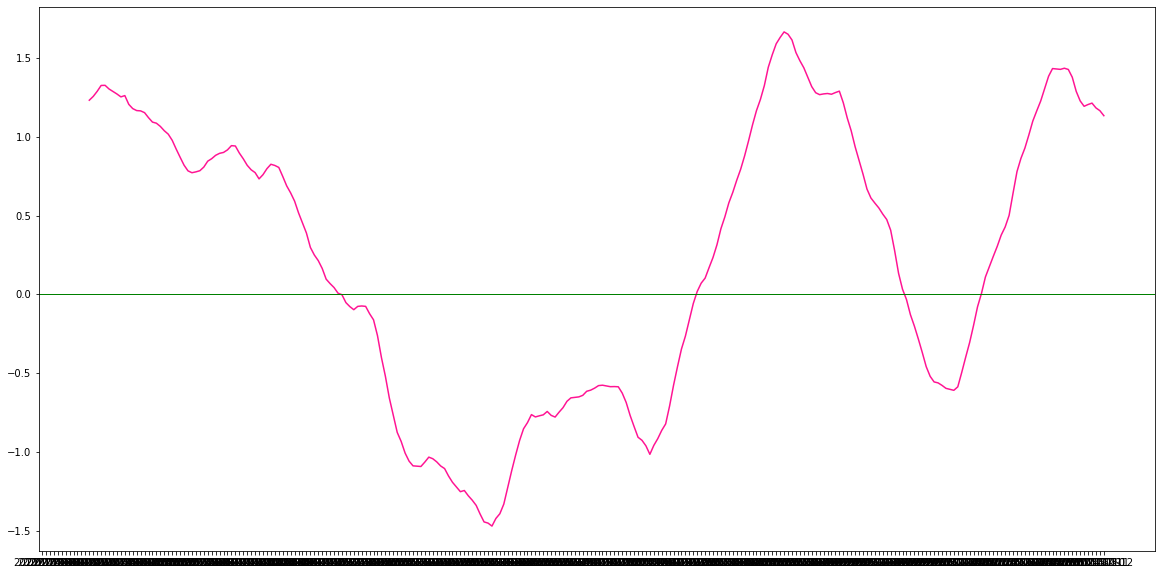

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA30;z_value;MA30;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

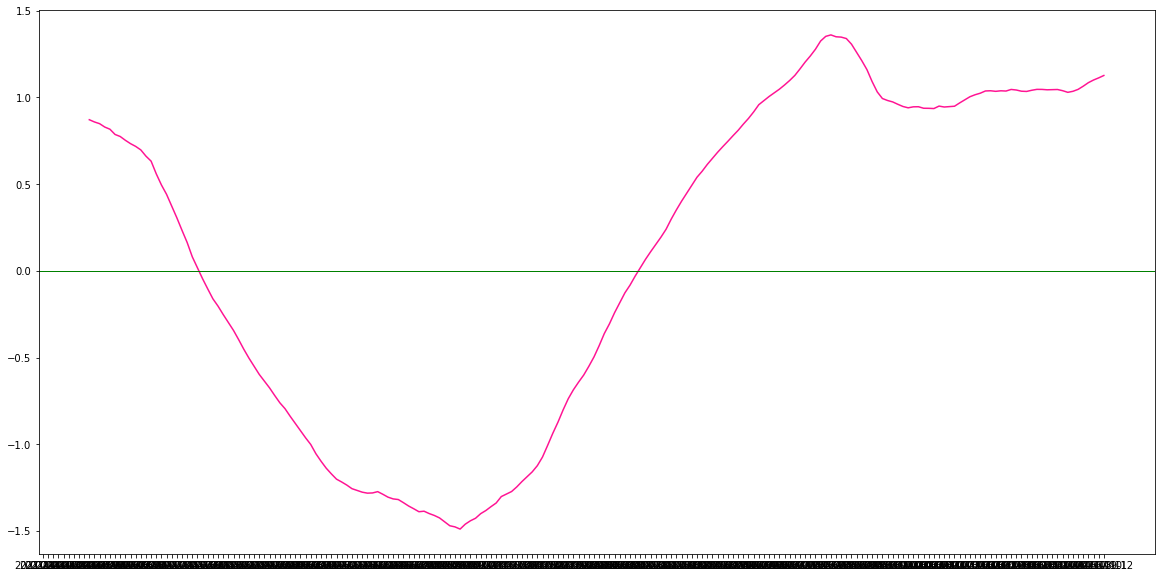

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA60;z_value;MA60;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

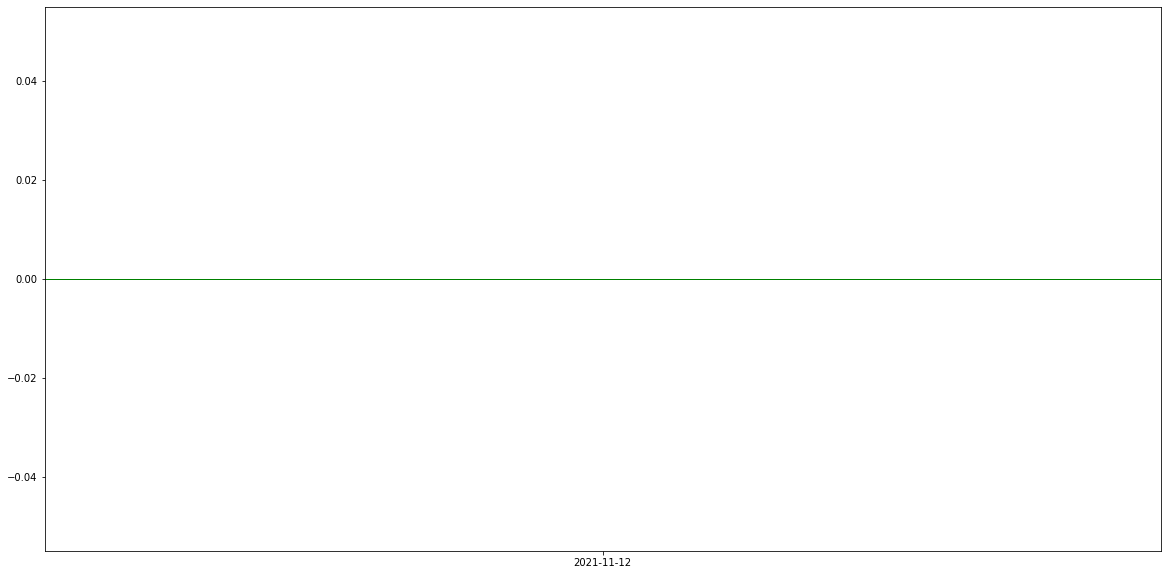

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['MA180;z_value;MA180;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=0, color='g', linewidth=1)

plt.show()

## VI. 이격도(disparity) 작업 밎 EDA

In [28]:
DF_price['disparity7;']= DF_price['price']/DF_price['MA7;']

In [30]:
DF_price['disparity14;']= DF_price['price']/DF_price['MA14;']

In [ ]:
DF_price['disparity30;']= DF_price['price']/DF_price['MA30;']

In [ ]:
DF_price['disparity60;']= DF_price['price']/DF_price['MA60;']

In [ ]:
DF_price['disparity180;']= DF_price['price']/DF_price['MA180;']

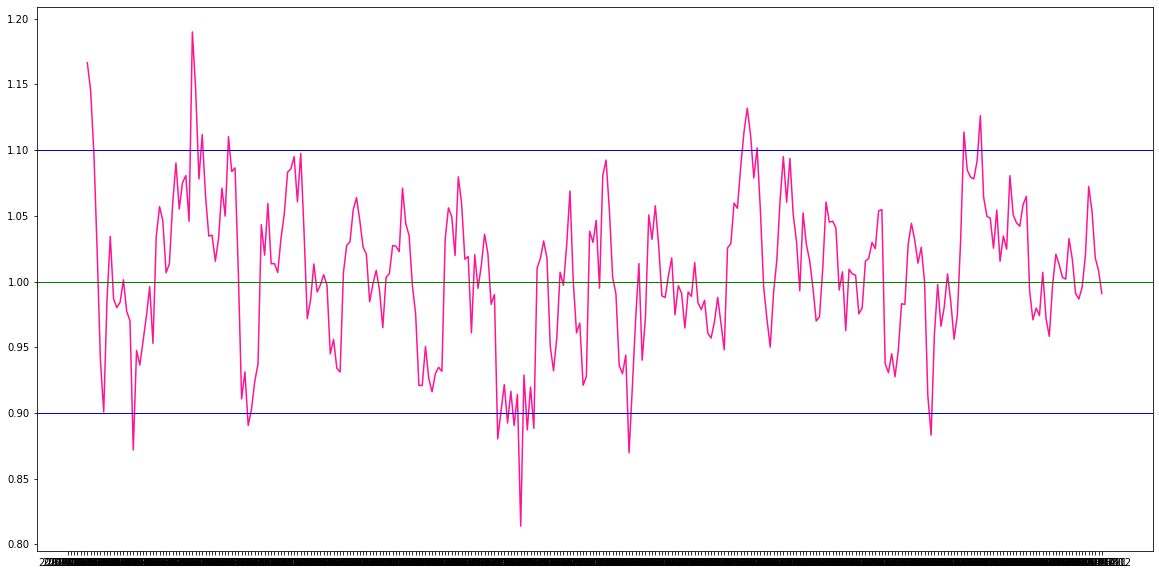

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity7;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=1, color='g', linewidth=1)
plt.axhline(y=1.1, color='b', linewidth=1)
plt.axhline(y=0.90, color='b', linewidth=1)

plt.show()


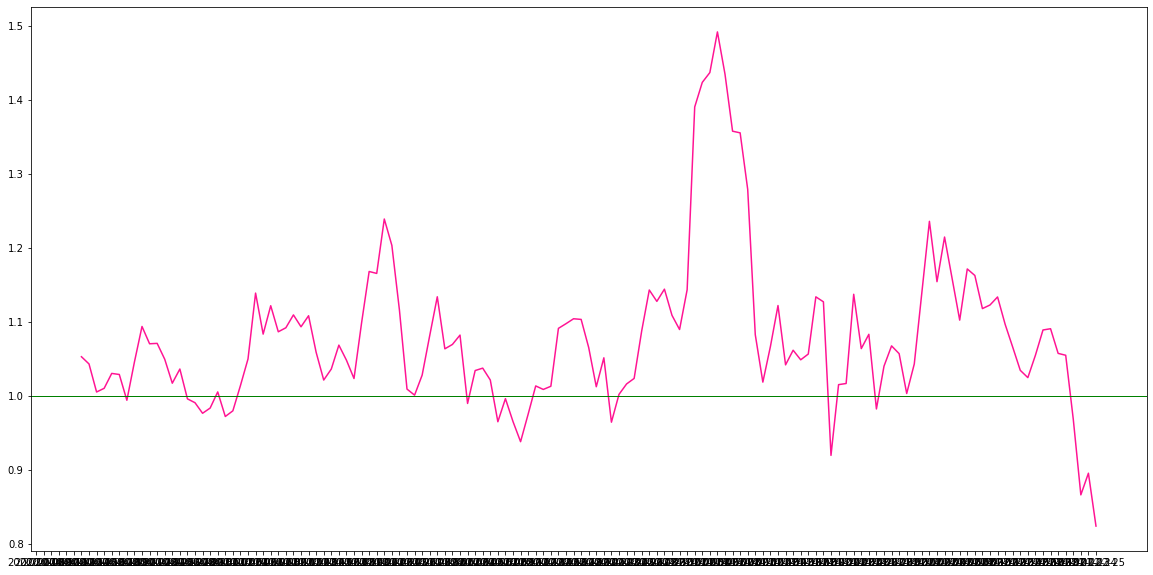

In [32]:
x_values = DF_price['date'][260:]	
# y_values = DF_price['s']
z_values = DF_price['disparity14;'][260:]

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')
# plt.axhline(y=1.1, color='b', linewidth=1)
# plt.axhline(y=0.90, color='b', linewidth=1)

plt.axhline(y=1, color='g', linewidth=1)

plt.savefig('Ethereum_MA14_Disparity.png')

plt.show()


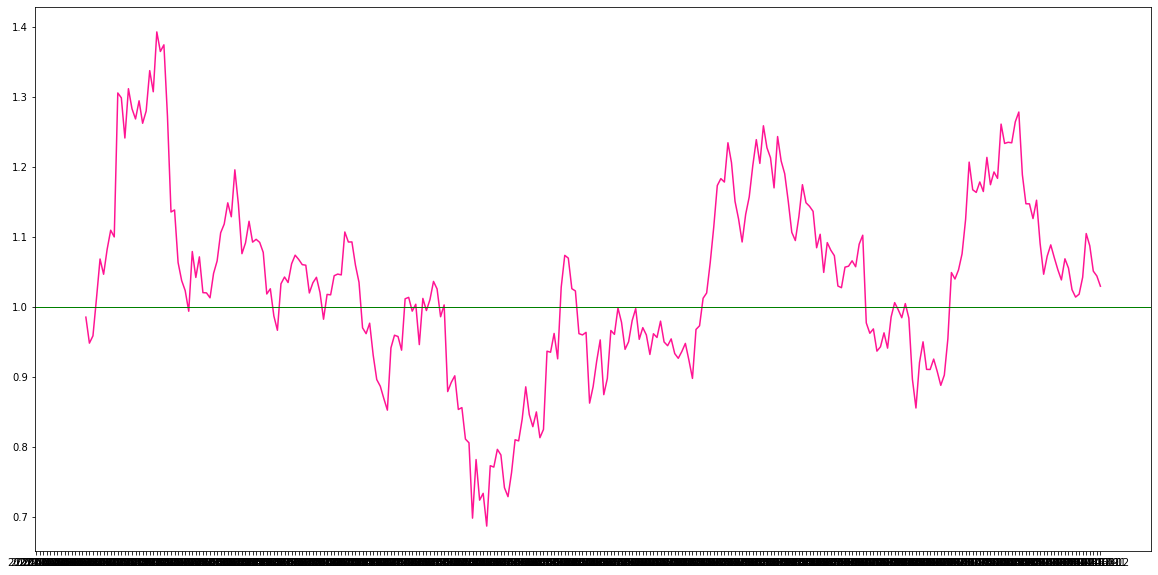

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity30;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')
# plt.axhline(y=1.25, color='b', linewidth=1)
# plt.axhline(y=0.75, color='b', linewidth=1)

plt.axhline(y=1, color='g', linewidth=1)

plt.show()


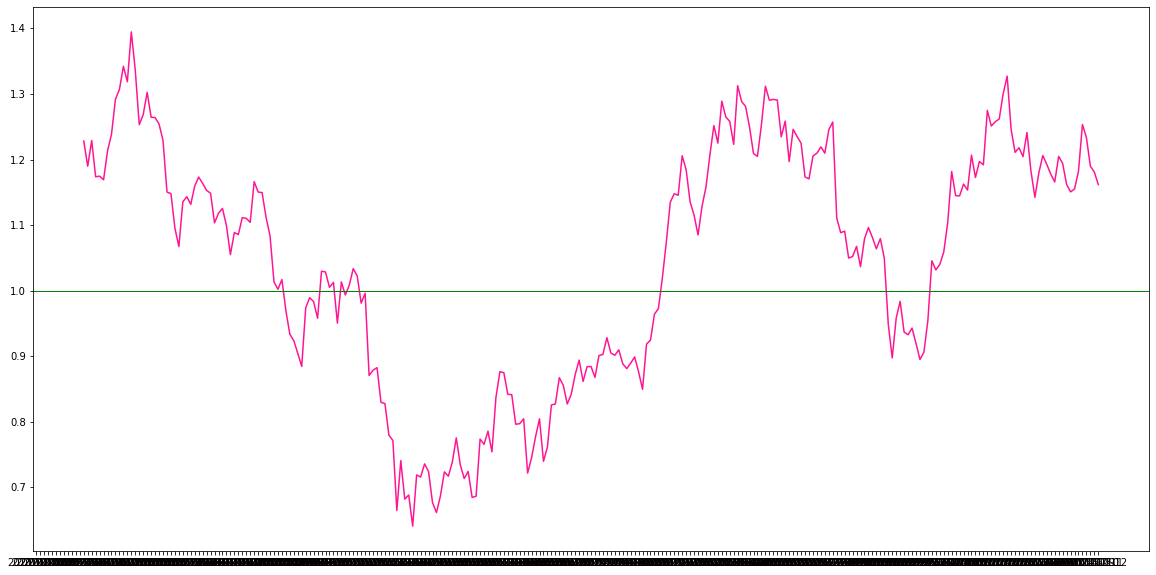

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity60;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=1, color='g', linewidth=1)

plt.show()


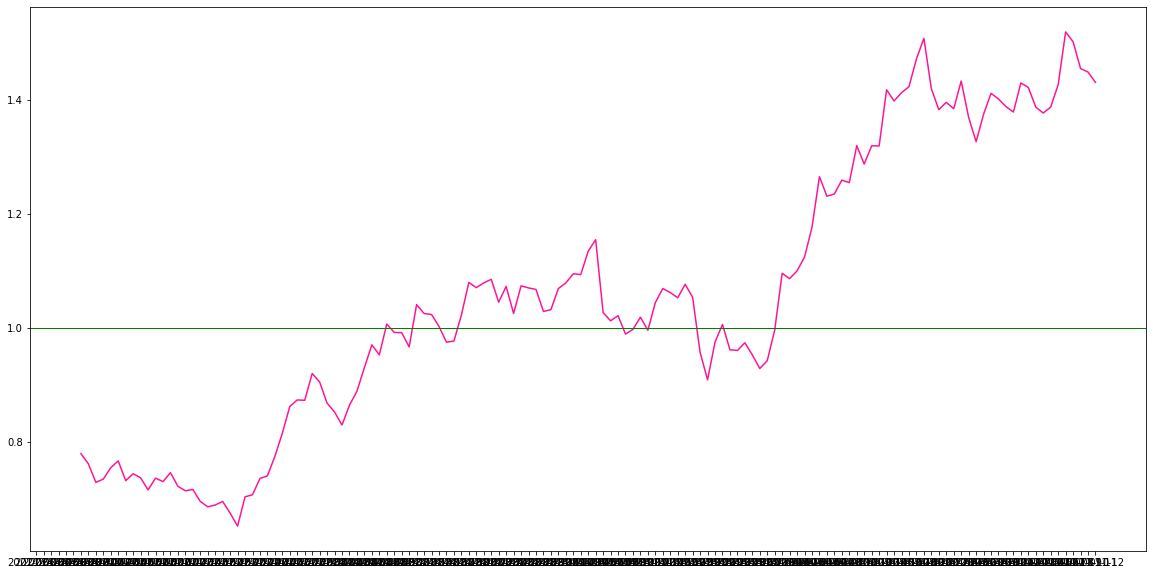

In [ ]:
x_values = DF_price['date']	
# y_values = DF_price['s']
z_values = DF_price['disparity180;']

plt.rcParams['figure.figsize'] = (20, 10)

fig, ax2 = plt.subplots()

ax2.invert_xaxis()
ax2.plot(x_values, z_values , color = 'deeppink')

plt.axhline(y=1, color='g', linewidth=1)

plt.show()